# Texas

Finally, we come to Texas.  Texas exploded with cases over the summer and holds the title for "Most New Cases in a Single Day" with a whopping 17,000! Let's dig in!

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('darkgrid')
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import helper_functions
from helper_functions import acf_pacf
from helper_functions import decompose_time_series
from helper_functions import train_test
from helper_functions import create_dataset
from helper_functions import fit_model
from helper_functions import test_RMSE
from helper_functions import train_RMSE
# from helper_functions import preprocess_data
from helper_functions import plot_loss
from helper_functions import LSTM_prediction_plot
import pmdarima as pm

Using TensorFlow backend.


One last time, we'll define this helper function for later.

In [2]:
# Instantiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, column):
    '''
    Input DataFrame and column name
    
    Function will create a numpy array from the values and set them to float.
    The values will be reshaped and normalized.  Next the dataset will be 
    split into training, validation, and test sets.
    
    Returns: Training, Validation, and Test sets
    '''
    import warnings
    warnings.filterwarnings('ignore')
    import itertools
    import pandas as pd
    import numpy as np
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    from matplotlib.pylab import rcParams
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error as MSE
    from statsmodels.tsa.seasonal import seasonal_decompose
    

    # Reset Index
    df = df.reset_index()
    
    # Create a series of only the values of the specified columns
    df = df[column].values
    
    # Reshape and convert to numpy array
    df = np.reshape(df, (-1, 1))
    
    # Normalize data
    df = scaler.fit_transform(df)
    
    # Define stopping points for Train and Validation Sets 
    train_stop = int(len(df) - 21)
    val_stop = int(train_stop + 7)
    
    # Define indices for train, val, and test
    train, val, test = df[0:train_stop,:], df[train_stop:val_stop,:], df[val_stop:,:]
    
    return train, val, test

# SARIMA

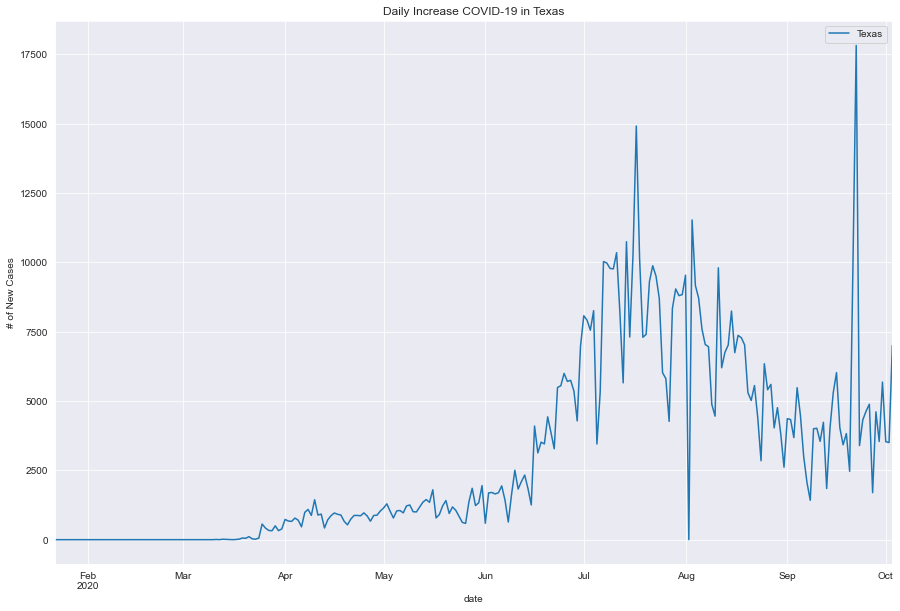

In [3]:
df = pd.read_csv('csv_files/national_positive_increase.csv')

# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Set to index
df = df.set_index('date')

df = df.asfreq('D')

# Texas
tx = df['TX_positiveIncrease']
tx.plot(figsize=(15, 10), label='Texas')

plt.ylabel('# of New Cases')
plt.title('Daily Increase COVID-19 in Texas')
plt.legend()
plt.show();


This plot never ceases to amaze me.  In August, you've got the Mariana's Trench of data with a sudden drop to 0, then you see Mount Everest over in September.  Just remarkable.  It's also going to make getting decent results very difficult.

Let's get started!

## ACF and PACF

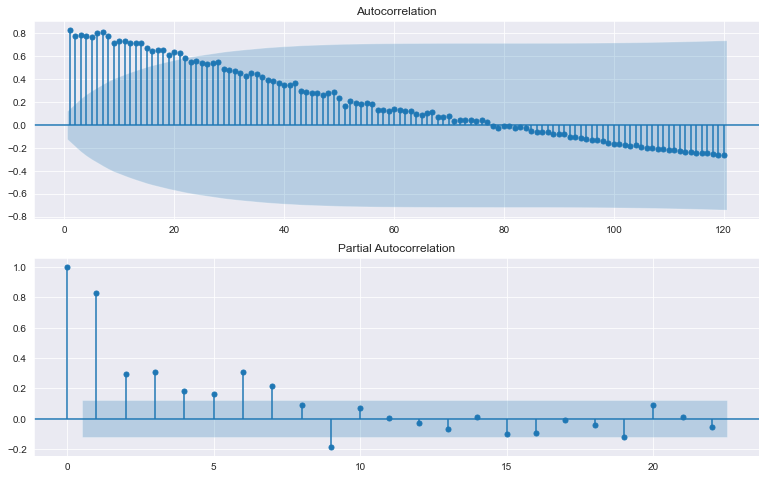

In [4]:
acf_pacf(tx)

ACF reveals that the MA(q) value could go all the way up to 21.  Interestingly, the PACF shows that the AR(p) value could be up to 7 (our highest yet).  Just like with all of the other states, the higher order dictates that AR will take precedence.

## Decomposition

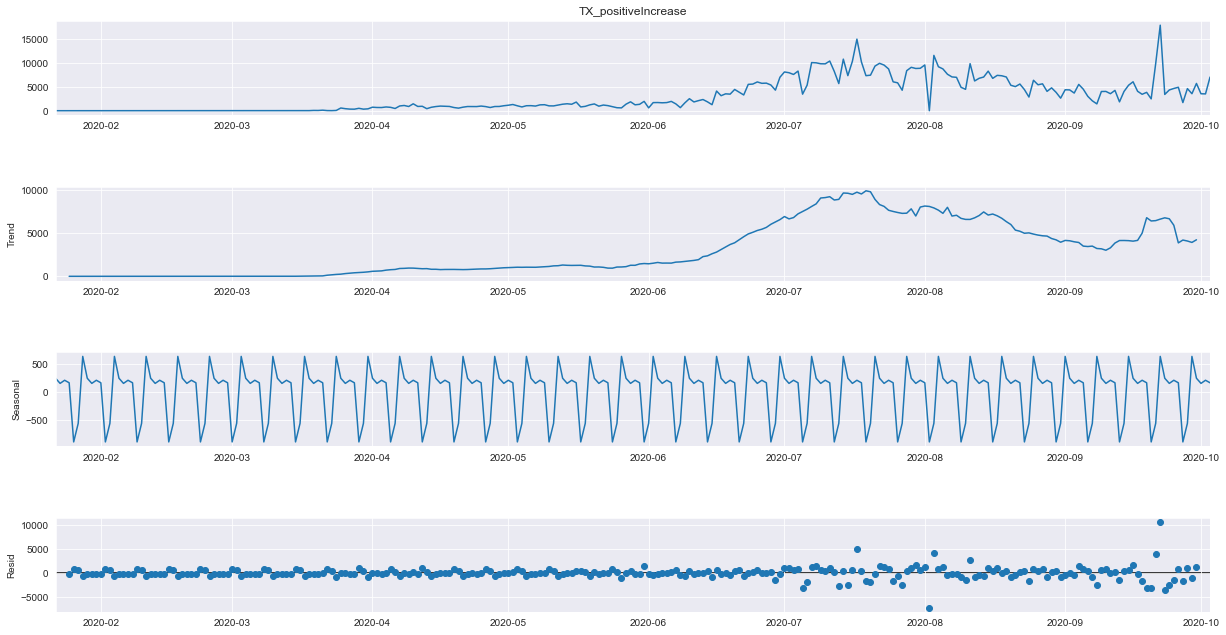

In [5]:
decompose_time_series(tx)

The seasonality is still weekly. The trend is exponentially positive, then relatively negative. This time, however, the there is another exponential increase again.  

The residuals seem to be more homoskedastic until the summer months.  There are a quite a few outliers which are pretty extreme in their ranges.

## Auto-ARIMA
Time for Auto-ARIMA

In [6]:
tx_results = pm.auto_arima(tx, information_criterion='aic', m=7 ,start_d=0, 
                           max_d=2,
                        start_p=1,start_q=1, max_p=7, max_q=21,
                        stepwise=True,trace=True,error_action='ignore',
                           suppress_warnings=True)
tx_results

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=4475.083, BIC=4496.331, Fit time=0.671 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=4584.305, BIC=4591.387, Fit time=0.011 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=4544.285, BIC=4558.450, Fit time=0.061 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4491.778, BIC=4505.943, Fit time=0.208 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4491.387, BIC=4509.094, Fit time=0.271 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 1, 7); AIC=4480.484, BIC=4505.273, Fit time=1.005 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=4486.974, BIC=4504.680, Fit time=0.394 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=4481.112, BIC=4505.901, Fit time=1.071 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=4495.188, BIC=4509.353, Fit time=0.233 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_o

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(0, 1, 1),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(1, 0, 1, 7), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

Interesting that the only lag that mattered was the first one (in the seasonal order).  Just as interesting is how the non-seasonal order implies that the order is ARMA(0, 1) with the moving average being the higher order.  This contradicts our observations from the ACF and PACF plots. 

## Train-Test Split

In [7]:
tx_train, tx_test = train_test(tx)

## Modeling

                                     SARIMAX Results                                     
Dep. Variable:               TX_positiveIncrease   No. Observations:                  205
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1727.134
Date:                           Fri, 16 Oct 2020   AIC                           3462.267
Time:                                   12:02:53   BIC                           3475.540
Sample:                               01-22-2020   HQIC                          3467.636
                                    - 08-13-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7557      0.030    -25.227      0.000      -0.814      -0.697
ar.S.L7        0.9043      0.058     15.597

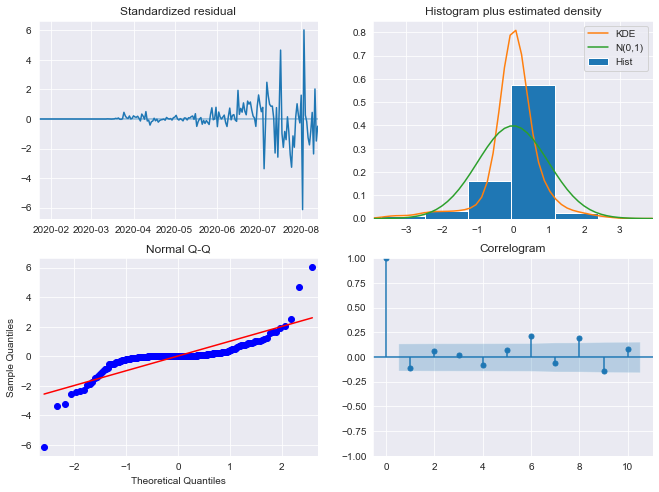

In [8]:
pdq = (0, 1, 1)
pdqs = (1, 0, 1, 7)
results = fit_model(tx_train, pdq=pdq, pdqs=pdqs)

## Results

Standardized Residuals: Residuals are straight up heteroskedastic.

Histogram: Just like all of the states, the KDE of the residuals follow a leptokurtic distributions

QQ-Plot: Not as bad as I expected considering all of the outliers.

Coefficients: All of the coefficients are statistically significant.

### RMSE and Predictions

SARIMA model RMSE on train data: 2122.50328


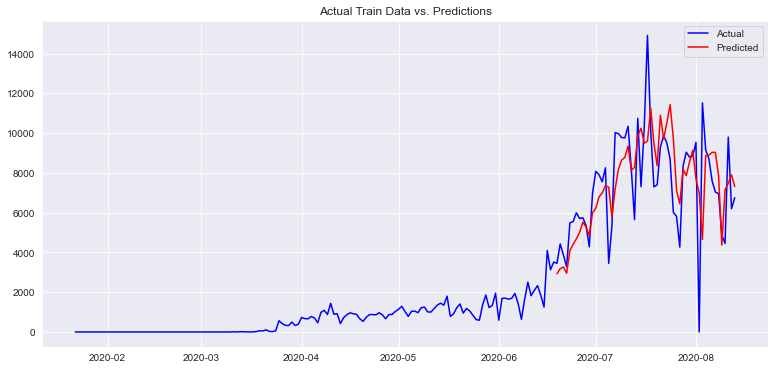

In [9]:
train_RMSE(tx_train, results, display = True)

SARIMA model RMSE on test data: 2691.54154


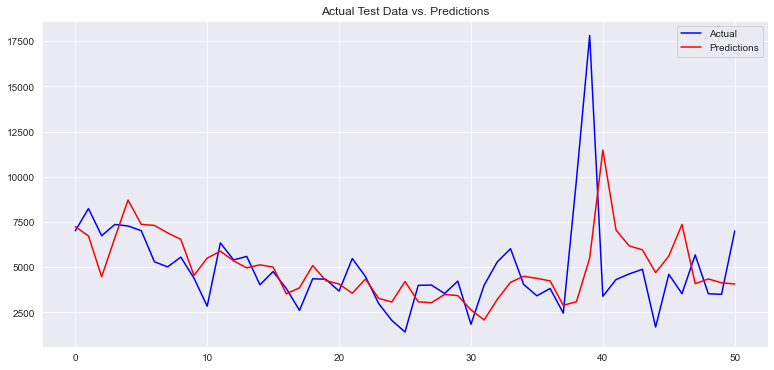

In [10]:
test_RMSE(tx_train, tx_test, pdq, pdqs, display=True)

* Train RMSE: 2122.503
* Test RMSE: 2691.542

Just like with New York, the Training set did better than the Test set. The fit of the predictions is still pretty good.  It serves a good, general purpose outline for making predictions.  

## Forecast

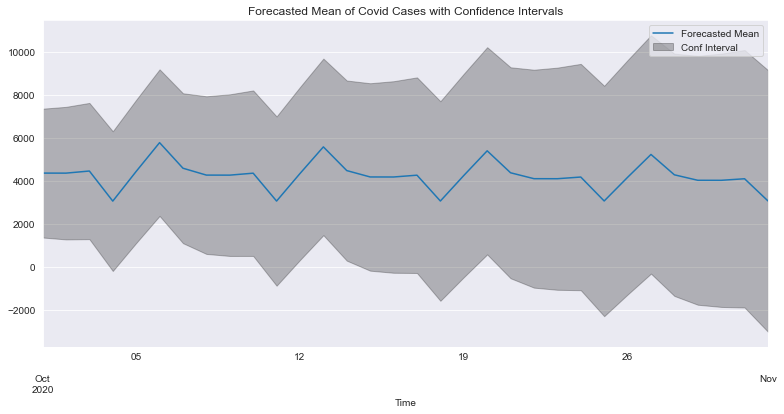

In [17]:
model = sm.tsa.statespace.SARIMAX(tx, order=pdq,seasonal_order=pdqs)
fit_model = model.fit()
output = fit_model.get_prediction(start='2020-10-01',end='2020-11-01', dynamic=True)
forecast_ci = output.conf_int()
fig, ax = plt.subplots(figsize=(13,6))
output.predicted_mean.plot(label='Forecasted Mean')
ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
plt.title('Forecasted Mean of Covid Cases with Confidence Intervals')
plt.xlabel('Time')
plt.legend(loc='best');
plt.show()

According to this forecast the average number of cases in Texas will vacillate between 3000 and 6000.  The spikes will get lower and lower, but the drop offs won't get much lower than 3000.  Again this is the estimated mean and the real number can fall anywhere within the confidence interval.  

Checking New York Times reports:

October 5, 2020:
   * Predicted: about 4000
   * Actual: 3977
October 12, 2020:
   * Predicted: about 4000
   * Actual: 4047

Interestingly, so far in October the lowest number of reported cases was on October 11th with 2975 and the highest was on October 7th, which had 5942 cases (NYT).  This is within the range of we mentioned earlier. 

# LSTM

## Split and Preprocess

In [11]:
tx_train, tx_val, tx_test = preprocess_data(tx, 'TX_positiveIncrease')

print(f"Train has {len(tx_train)} values")
print(f"Validation has {len(tx_val)} values")
print(f"Test has {len(tx_test)} values")

Train has 235 values
Validation has 7 values
Test has 14 values


## Reshape

In [12]:
look_back = 1

X_train, y_train = create_dataset(tx_train, look_back)
X_val, y_val = create_dataset(tx_val, look_back)
X_test, y_test = create_dataset(tx_test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Modeling 

In [13]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=500, batch_size=70, 
                    validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=100)], 
                    verbose=1, shuffle=False)

model.summary()

Train on 233 samples, validate on 5 samples
Epoch 1/500
233/233 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0619
Epoch 2/500
233/233 [==============================] - 0s 51us/step - loss: 0.0524 - val_loss: 0.0550
Epoch 3/500
233/233 [==============================] - 0s 51us/step - loss: 0.0480 - val_loss: 0.0486
Epoch 4/500
233/233 [==============================] - 0s 51us/step - loss: 0.0441 - val_loss: 0.0427
Epoch 5/500
233/233 [==============================] - 0s 51us/step - loss: 0.0407 - val_loss: 0.0373
Epoch 6/500
233/233 [==============================] - 0s 47us/step - loss: 0.0374 - val_loss: 0.0324
Epoch 7/500
233/233 [==============================] - 0s 56us/step - loss: 0.0351 - val_loss: 0.0282
Epoch 8/500
233/233 [==============================] - 0s 56us/step - loss: 0.0328 - val_loss: 0.0244
Epoch 9/500
233/233 [==============================] - 0s 51us/step - loss: 0.0310 - val_loss: 0.0211
Epoch 10/500
233/233 [=================

## RMSE

In [14]:
from sklearn.metrics import mean_absolute_error as MAE

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale for interpretation
train_predict = scaler.inverse_transform(train_predict)
y_train_rescaled = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_rescaled = scaler.inverse_transform([y_test])

print('Train Mean Absolute Error:', MAE(y_train_rescaled[0], 
                                        train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(MSE(y_train_rescaled[0], 
                                               train_predict[:,0])))
print('Test Mean Absolute Error:', MAE(y_test_rescaled[0], 
                                       test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(MSE(y_test_rescaled[0], 
                                              test_predict[:,0])))

Train Mean Absolute Error: 830.5378306638529
Train Root Mean Squared Error: 1512.815962595251
Test Mean Absolute Error: 3486.467315673828
Test Root Mean Squared Error: 5225.312835483195


* Train RMSE: 1512.816
* Test RMSE: 5225.313

Well, everything's bigger in Texas.  I expected this considering all of the outliers.  The large difference between the Train and Test results point towards overfitting.  Let's check the model loss.

## Model Loss

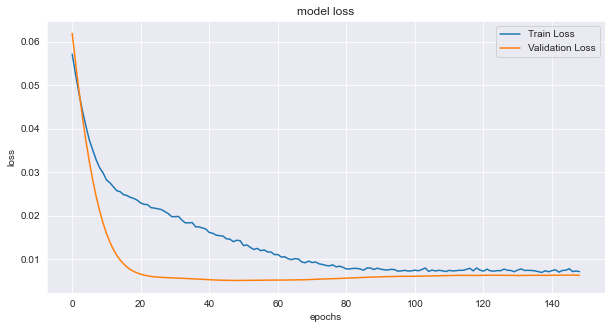

In [15]:
plot_loss(history)

The train and validation sets converge, but I can honestly see how this could be overfit.  There is also the fact that the training set contains that major infamous spike up to 17,000.  Let's plot out the predictions.

## Predictions

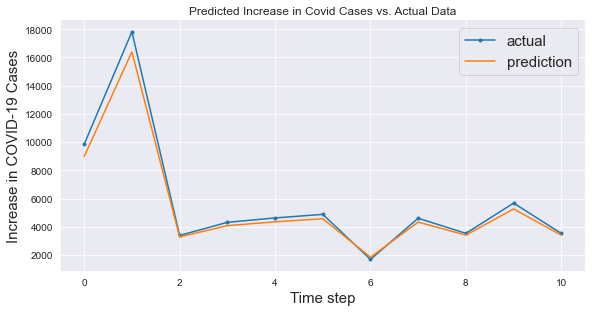

In [16]:
LSTM_prediction_plot(test_predict, y_test_rescaled)

Ok, so the predictions are still looking very tight.  The model definitely struggled a little with predicting that spike.  It is still much closer than the SARIMA model's prediction.

Let's try to decreasing our `patience` parameter and seeing if that helps.

## Patience = 50

In [34]:
look_back = 1

X_train, y_train = create_dataset(tx_train, look_back)
X_val, y_val = create_dataset(tx_val, look_back)
X_test, y_test = create_dataset(tx_test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

p50_model = Sequential()
p50_model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
p50_model.add(Dropout(0.2))
p50_model.add(Dense(1))
p50_model.compile(loss='mean_squared_error', optimizer='adam')

p50_history = p50_model.fit(X_train, y_train, epochs=500, batch_size=70, 
                    validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=50)], 
                    verbose=1, shuffle=False)

p50_model.summary()

Train on 233 samples, validate on 5 samples
Epoch 1/500
233/233 [==============================] - 1s 5ms/step - loss: 0.0637 - val_loss: 0.0697
Epoch 2/500
233/233 [==============================] - 0s 60us/step - loss: 0.0592 - val_loss: 0.0626
Epoch 3/500
233/233 [==============================] - 0s 103us/step - loss: 0.0552 - val_loss: 0.0559
Epoch 4/500
233/233 [==============================] - 0s 81us/step - loss: 0.0505 - val_loss: 0.0497
Epoch 5/500
233/233 [==============================] - 0s 69us/step - loss: 0.0467 - val_loss: 0.0441
Epoch 6/500
233/233 [==============================] - 0s 77us/step - loss: 0.0437 - val_loss: 0.0389
Epoch 7/500
233/233 [==============================] - 0s 116us/step - loss: 0.0407 - val_loss: 0.0343
Epoch 8/500
233/233 [==============================] - 0s 64us/step - loss: 0.0381 - val_loss: 0.0301
Epoch 9/500
233/233 [==============================] - 0s 73us/step - loss: 0.0362 - val_loss: 0.0265
Epoch 10/500
233/233 [===============

Epoch 80/500
233/233 [==============================] - 0s 94us/step - loss: 0.0091 - val_loss: 0.0053
Epoch 81/500
233/233 [==============================] - 0s 86us/step - loss: 0.0099 - val_loss: 0.0054
Epoch 82/500
233/233 [==============================] - 0s 64us/step - loss: 0.0094 - val_loss: 0.0054
Epoch 83/500
233/233 [==============================] - 0s 82us/step - loss: 0.0089 - val_loss: 0.0054
Epoch 84/500
233/233 [==============================] - 0s 81us/step - loss: 0.0089 - val_loss: 0.0054
Epoch 85/500
233/233 [==============================] - 0s 69us/step - loss: 0.0089 - val_loss: 0.0055
Epoch 86/500
233/233 [==============================] - 0s 81us/step - loss: 0.0092 - val_loss: 0.0055
Epoch 87/500
233/233 [==============================] - 0s 124us/step - loss: 0.0088 - val_loss: 0.0055
Epoch 88/500
233/233 [==============================] - 0s 60us/step - loss: 0.0088 - val_loss: 0.0056
Epoch 89/500
233/233 [==============================] - 0s 103us/step - 

In [35]:
train_predict = p50_model.predict(X_train)
test_predict = p50_model.predict(X_test)

# Invert predictions to original scale for interpretation
train_predict = scaler.inverse_transform(train_predict)
y_train_rescaled = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_rescaled = scaler.inverse_transform([y_test])

print('Train Mean Absolute Error:', MAE(y_train_rescaled[0], 
                                        train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(MSE(y_train_rescaled[0], 
                                               train_predict[:,0])))
print('Test Mean Absolute Error:', MAE(y_test_rescaled[0], 
                                       test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(MSE(y_test_rescaled[0], 
                                              test_predict[:,0])))

Train Mean Absolute Error: 879.3225857321285
Train Root Mean Squared Error: 1524.2364388594954
Test Mean Absolute Error: 3470.2135620117188
Test Root Mean Squared Error: 5174.947721564023


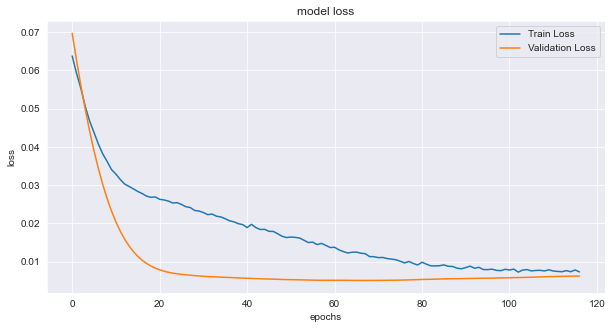

In [36]:
plot_loss(p50_history)

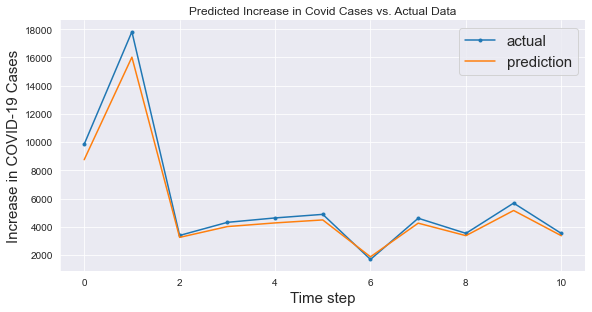

In [37]:
LSTM_prediction_plot(test_predict, y_test_rescaled)

## Results 

The difference is negligible, with the main difference being that the fit of the predictions is slightly worse in some cases.

This is a similar issue that we had with New York.  The SARIMA Model had the better RMSE scores, while the LSTMs have more accurate predictions.  I honestly think that in these cases, either one of these models is a good choice for making predictions.